### **Top-down approach**
Based on *Gowda et al., 2022.*

Following data from the aforementioned paper, we are building a consortia composed by two *Pseudomonas putida* strains with different denitrification capabilities.

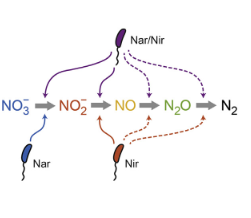

For this example, one strain will have Nar phetotype, while the other strain will have Nir phenotype.
We are going to use the model iJN1463 for both strains, making the appropiated modifications to obtain the desired phenotype for each case.

1. Look for the correspondence between these reactions, metabolites and sbml notation.

| **Metabolite Name** | **SBML id** |
|---------------------|-------------|
| Nitrate             | no3         |
| Nitrite             | no2         |
| Nitric oxide        | no          |
| Nitrous oxide       | n2o         |
| Nitrogen            | n2          |  

<br />


| **Reaction Name**       | **SBML id** |
|-------------------------|-------------|
| Nitrate reductase       | NITR        |
| Nitrite reductase       | NITR_NO     |
| Nitric oxide reductase  | NORx        |
| Nitrous oxide reductase | N2OR        |



---


2. Load the model and search if the metabolites and reactions are already included in the model.
  

> 2.1. Load the model



In [ ]:
import cobra as cb

model= cb.io.load_model('iJN1463')



>2.2. Create dictionaries for ids of metabolites and reactions of interest



In [ ]:
met_id={'nitrate': 'no3', 'nitrite': 'no2', 'nitric_oxide': 'no', 'nitrous_oxide': 'n2o', 'nitrogen': 'n2'}
rxn_id={'nitrate_reductase': 'NITR', 'nitrite_reductase': 'NITR_NO', 'nitric_oxide_reductase': 'NORx', 'nitrous_oxide_reductase': 'N2OR'}



> 2.3. Get all the metabolites id from the model



In [ ]:
modelmet=model.metabolites
modelmetid=[met.id for met in modelmet]

> 2.4. Remove the compartment from the id of the metabolite

In [ ]:
modelmetid_wo_compartment=[met.id.split('_')[0] for met in modelmet]

>2.5. Get all the reactions id from the model

In [ ]:
modelrxn=model.reactions
modelrxnid=[rxn.id for rxn in modelrxn]

> 2.6. Get the metabolites not present in the model

In [ ]:
mets_in_model=[]
mets_missing=[]
for (km,vm) in met_id.items():
  if vm not in modelmetid_wo_compartment:
    print("""Metabolite '%s' not found in model""" %(vm))
    mets_missing.append(vm)
  else:
    mets_in_model.append(str(vm)+'_')


Metabolite 'n2o' not found in model
Metabolite 'n2' not found in model


>2.7 Get the reactions not present in the model

In [ ]:
rxns_missing=[]
for (kr,vr) in rxn_id.items():
  if vr not in modelrxnid:
    print("""Reaction '%s' not found in model""" %(vr))
    rxns_missing.append(vr)


Reaction 'NITR_NO' not found in model
Reaction 'NORx' not found in model
Reaction 'N2OR' not found in model




---


3. Modify the model to add missing reactions and metabolites
>3.1. We need to make sure that, for our study case, the first two metabolites of the patway, "no3" and "no2", are present in the extracellular compartment, because the model needs to take it from the culture media.

In [ ]:
for met in modelmetid:
  if met.startswith("no3_e") or met.startswith("no2_e"):
    print(True)


True
True


>>3.1.1. In our case, we see that the extracellular version of the metabolite "no3" and "no2" is already available in the model. In case they weren't, we would have to include them in the model.

>3.2. As our selected pathway occurs in the periplasm, we have to make sure that a transport reaction is already included.

In [ ]:
mets_of_interest=['no3', 'no2']
for r in modelrxnid:
    sustrate_compartiments = {met.id[:-2] : met.id[-2:] for met in model.reactions.get_by_id(r).reactants}
    product_compartiments = {met.id[:-2] : met.id[-2:] for met in model.reactions.get_by_id(r).products}
    shared_mets = set(sustrate_compartiments.keys()) & set(product_compartiments.keys())
    for i in mets_of_interest:
      if i in shared_mets:
        if len(shared_mets) >= 1 and all([sustrate_compartiments[i] != product_compartiments[i]]):
          print('%s is a transport reaction for metabolite: %s, between the compartments: %s and %s' %(r,i, sustrate_compartiments[i], product_compartiments[i]))



NO2t2rpp is a transport reaction for metabolite: no2, between the compartments: _p and _c
NO2tex is a transport reaction for metabolite: no2, between the compartments: _e and _p
NO3t2pp is a transport reaction for metabolite: no3, between the compartments: _p and _c
NO3abcpp is a transport reaction for metabolite: no3, between the compartments: _p and _c
NO3tex is a transport reaction for metabolite: no3, between the compartments: _e and _p


>> We also have to check that an existing exchange reaction for both metabolites, as they have to be able to enter and leave the system.


In [ ]:
#Check if exchange reaction exist

for m in mets_of_interest:
  if 'EX_'+m+'_e' in modelrxnid:
    print('An exchange reaction for the metabolite %s is in the model' %(m))


An exchange reaction for the metabolite no3 is in the model
An exchange reaction for the metabolite no2 is in the model


Now we have an understanding of what the model contains and lacks for this specific pathway. We are going to work for each strain separately. We'll start with the Nar strain.
The Nar strain needs to have:
- An exchange reaction for NO3 and NO2, as well as transport reactions among them.
- Nitrate reductase reaction.
- The nexts reactions from the pathway removed, so flux can't go there.

>>3.3. Modifications of Nar strain
>>>3.3.1. Removing reactions from Nir phenotype

In [ ]:
#For removing reactions, we are going to close its boundaries, so flux can't go through.
#In the WT model, NO2 goes through reaction NTRIR2x, so we need to close it.
import copy
model_Nar=copy.deepcopy(model)
model_Nar.reactions.EX_no3_e.bounds=(-15,-15)
model_Nar.reactions.NTRIR2x.bounds=(0,0)
model_Nar.summary()


Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.001975,0,0.00%
cl_e,EX_cl_e,0.001975,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001421,0,0.00%
cu2_e,EX_cu2_e,0.001317,0,0.00%
fe2_e,EX_fe2_e,0.006864,0,0.00%
glc__D_e,EX_glc__D_e,6,6,100.00%
k_e,EX_k_e,0.07408,0,0.00%
mg2_e,EX_mg2_e,0.003292,0,0.00%
mn2_e,EX_mn2_e,0.001317,0,0.00%
mobd_e,EX_mobd_e,0.001525,0,0.00%


The modifications regarding the Nar strain are all done.
Now, we will focus on the Nir strain.

The modifications we need to perform are:
- Introduction of reactions NITR_NO, NORx, N2OR
- Introduction of metabolites NO, N2O, N2
- Introduction of transport reaction for N2 between periplasm and extracelullar compartments
- Introduction of exchange reaction for N2

In [ ]:
model_Nir=copy.deepcopy(model)

#Introduction of needed reactions
# NITR_NO
reaction = cb.Reaction('NITR_NO')
reaction.name = 'Nitrite reductase (NO-forming)'
reaction.subsystem = ''
reaction.lower_bound = 0  #
reaction.upper_bound = 1000  # This is the default

#metabolites associated with the reaction

focytc_c=model_Nir.metabolites.focytc_c
h_c=model_Nir.metabolites.h_c
no2_c=model_Nir.metabolites.no2_c
ficytc_c=model_Nir.metabolites.ficytc_c
h2o_c=model_Nir.metabolites.h2o_c
no_c=model_Nir.metabolites.no_c

reaction.add_metabolites({
    focytc_c: -1,
    no2_c: -1,
    h_c: -2,
    ficytc_c: 1,
    no_c:1,
    h2o_c: 1,})

reaction.gene_reaction_rule = ''

model_Nir.add_reactions([reaction])

In [ ]:
#Introduction of needed reactions
# NORx
reaction = cb.Reaction('NORx')
reaction.name = 'Nitric oxide reductase'
reaction.subsystem = ''
reaction.lower_bound = 0  #
reaction.upper_bound = 1000  # This is the default

#metabolites associated with the reaction

focytc_c=model_Nir.metabolites.focytc_c
h_c=model_Nir.metabolites.h_c
no_c=model_Nir.metabolites.no_c
ficytc_c=model_Nir.metabolites.ficytc_c
h2o_c=model_Nir.metabolites.h2o_c
n2o_c=cb.Metabolite(
    'n2o_c',
    formula='N2O',
    name='Nitrous oxide',
    compartment='c',
    charge=0)

reaction.add_metabolites({
    focytc_c: -2,
    no_c: -2,
    h_c: -2,
    ficytc_c: 2,
    n2o_c:1,
    h2o_c: 1,})

reaction.gene_reaction_rule = ''

model_Nir.add_reactions([reaction])

In [ ]:
#Introduction of needed reactions
# N2OR
reaction = cb.Reaction('N2OR')
reaction.name = 'Nitrous oxide reductase (nadh)'
reaction.subsystem = ''
reaction.lower_bound = 0  #
reaction.upper_bound = 1000  # This is the default

#metabolites associated with the reaction

nadh_c=model_Nir.metabolites.nadh_c
h_c=model_Nir.metabolites.h_c
n2o_c=model_Nir.metabolites.n2o_c
nad_c=model_Nir.metabolites.nad_c
h2o_c=model_Nir.metabolites.h2o_c
n2_c=cb.Metabolite(
    'n2_c',
    formula='N2',
    name='dinitrogen',
    compartment='c',
    charge=0)

reaction.add_metabolites({
    nadh_c: -1,
    n2o_c: -1,
    h_c: -1,
    nad_c: 1,
    n2_c:1,
    h2o_c: 1,})

reaction.gene_reaction_rule = ''

model_Nir.add_reactions([reaction])

In [ ]:
#Introduction of needed reactions
# N2TR
reaction = cb.Reaction('N2TR')
reaction.name = 'Dinitrate transport'
reaction.subsystem = ''
reaction.lower_bound = 0  #
reaction.upper_bound = 1000  # This is the default

#metabolites associated with the reaction

n2_c=model_Nir.metabolites.n2_c
n2_e=cb.Metabolite(
    'n2_e',
    formula='N2',
    name='dinitrogen',
    compartment='e',
    charge=0)

reaction.add_metabolites({
    n2_c: -1,
    n2_e: 1})

reaction.gene_reaction_rule = ''

model_Nir.add_reactions([reaction])

In [ ]:
#introduction of exchange reaction for metabolite N2
model_Nir.add_boundary(model_Nir.metabolites.get_by_id("n2_e"), type="exchange")


Reaction identifier,EX_n2_e
Name,dinitrogen exchange
Memory address,0x7f7e7fe33fd0
Stoichiometry,n2_e <=> dinitrogen <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
#Test the construction to see if it works
model_Nir.reactions.EX_no_e.upper_bound=0
model_Nir.reactions.EX_o2_e.lower_bound=-5
model_Nir.reactions.EX_no2_e.bounds=(-5,-5)
model_Nir.reactions.EX_no3_e.bounds=(0,0)
model_Nir.reactions.NTRIR2x.bounds=(0,0)
model_Nir.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.001657,0,0.00%
cl_e,EX_cl_e,0.001657,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001192,0,0.00%
cu2_e,EX_cu2_e,0.001105,0,0.00%
fe2_e,EX_fe2_e,0.005759,0,0.00%
glc__D_e,EX_glc__D_e,6,6,100.00%
h_e,EX_h_e,7.482,0,0.00%
k_e,EX_k_e,0.06215,0,0.00%
mg2_e,EX_mg2_e,0.002762,0,0.00%
mn2_e,EX_mn2_e,0.001105,0,0.00%


 4. Now that our two models are ready, we are going to make a consortium to reflect the same behaviour as our reference.
To do so, we are going to use FLYCOP//COMETS???????????

----------------------------------------------------------------------------

Comets works slightly different than running a FBA in cobra. First, we have to set up the layout, which accounts for the models to use, their respectives initial biomass and the culture media. Then, we have to set up the parameters, and finally we can run the simulation with comets.

  4.1. Set up layout

In [ ]:
# Creation of the consortium with comets
import cometspy as c

#converting our models to comets format
model_Nar_comets=c.model(model_Nar)
model_Nir_comets=c.model(model_Nir)


#saving the models in comets format

model_Nar_comets.id='Nar_strain'

model_Nir_comets.id='Nir_strain'


In [ ]:

layout=c.layout([model_Nir_comets,model_Nar_comets])

layout.initial_pop=[[0.0,0.0,float(0.01),float(0.01)]] #Both initial biomasses are going to be 0.01g
layout.add_typical_trace_metabolites()
layout.set_specific_metabolite("glc__D_e", 40) #Glucose 20mM is added to the media
layout.set_specific_metabolite("no3_e", 20) #NO3 20mM is added to the media
layout.set_specific_metabolite("pqqA_kt_c", 2)


  4.2. Set up parameters

In [ ]:
params=c.params()
params.all_params['maxCycles']=170
params.all_params['timeStep']=0.1
params.all_params['spaceWidth']=0.05
params.all_params['allowCellOverlap']= True
params.all_params['deathRate']= 0.0
params.all_params['numRunThreads']= 8
params.all_params['maxSpaceBiomass']= 1000
params.all_params['defaultVmax']=20
params.all_params['showCycleTime']=True
params.all_params['writeTotalBiomassLog']=True
params.all_params['writeMediaLog']=True
params.all_params['writeFluxLog']=True
params.all_params['useLogNameTimeStamp']=False
params.all_params['FluxLogRate']=1
params.all_params['MediaLogRate']=1
params.all_params['exchangestyle']='Standard FBA'

4.3. Run comets simulation

In [ ]:
simulation=c.comets(layout,params)
simulation.run(delete_files=True)


Running COMETS simulation ...


/home/ana/anaconda3/envs/moadb/lib/python3.9/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/ana/anaconda3/envs/moadb/lib/python3.9/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/ana/anaconda3/envs/moadb/lib/python3.9/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/ana/anaconda3/envs/moadb/lib/python3.9/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=Fa

Done!


Now, we have to create a dataFrame containing the strains and metabolites we are interested in representing graphically

    4.4. Create dataframe for both strains and important metabolites

In [ ]:
import numpy as np
media = simulation.media #We get the media composition results
dataframe=simulation.total_biomass #We get the biomass results
columns=['cycle','Nar_strain', 'Nir_strain']
dataframe.columns=columns
max_cycles=params.all_params['maxCycles']
"""For each metabolite a column with all zeros is added to the dataframe and each row that contains a value
    (metabolite concentration)is changed in the dataframe"""
for d in ['glc__D_e', 'no3_e', 'n2_e','no2_e']:
    met =media[media['metabolite'] == d]
    temp=np.zeros(max_cycles+1) #Create an array with all zeros
    dataframe[d]=temp #We add it to the dataframe
    j=1
    while j < (max_cycles+1): #For each cycle
        if (met.cycle==j).any(): #If the row exists
            dataframe.loc[j-1,d] = float(met[met['cycle']==j]['conc_mmol']) #Its dataframe value is changed
        j+=1

    if float(dataframe[str(d)].iloc[-1])==0:
            if dataframe[d].iloc[-2]==0:
                continue
            else:
                dataframe[d].iloc[-1]=dataframe[d].iloc[-2]

/tmp/ipykernel_35710/3318924532.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[d].iloc[-1]=dataframe[d].iloc[-2]
/tmp/ipykernel_35710/3318924532.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[d].iloc[-1]=dataframe[d].iloc[-2]


Finally, we are going to make a graph of the results

    4.5. Making a graph

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
for i in ['Nar_strain', 'Nir_strain']:
# Add traces
    fig.add_trace(
    go.Scatter(x=dataframe['cycle']*0.1, y=dataframe[i], name=i),
    secondary_y=False,
    )
for m in ['glc__D_e', 'no3_e', 'n2_e','no2_e']:
    fig.add_trace(
    go.Scatter(x=dataframe['cycle']*0.1, y=dataframe[m], name=m),
    secondary_y=True,
    )

# Set x-axis title
fig.update_xaxes(title_text="time (h)")

# Set y-axes titles
fig.update_yaxes(title_text="<b>biomass</b> (g/L)", secondary_y=False)
fig.update_yaxes(title_text="<b>metabolite conc</b> (mM)", secondary_y=True)
fig.update_layout(legend=dict(

    y=1.2,
    orientation='h',

    x=0.01
),height=400, width=800,title_text="Denitrification process",template='simple_white')
fig.show()

4.6. Making the graph in the paper

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
go.Scatter(x=dataframe['cycle']*0.1, y=dataframe['no3_e'], name='Nitrate'),
secondary_y=True,
)
fig.add_trace(
go.Scatter(x=dataframe['cycle']*0.1, y=dataframe['no2_e'], name='Nitrite'),
secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="time (h)")

# Set y-axes titles
fig.update_yaxes(title_text="<b>metabolite conc</b> (mM)", secondary_y=True)
fig.update_layout(legend=dict(

    y=1.2,
    orientation='h',

    x=0.01
),height=400, width=800,title_text="Denitrification process",template='simple_white')
fig.show()

FLYCOP run
 Create a list with the models generated list



In [ ]:
consortia=[model_transformer_comets,model_producer_comets]


'5.14.1'

Create a FLYCOP2 object


In [ ]:
FLYCOP_optimization=FLYCOP2()


Select the COMETS simulator


In [ ]:
FLYCOP_optimization.create_simulator(simulator_type="COMETS")


Load the consortia into FLYCOP


In [ ]:
FLYCOP_optimization.load_consortia(consortia)


Set the COMETS parameters


In [ ]:
FLYCOP_optimization.set_simulator_params(params)


Load the COMETS scenario created


In [ ]:
FLYCOP_optimization.create_scenario()
FLYCOP_optimization.set_scenario(n2_scenario)



Set the optimization space.

In [ ]:
FLYCOP_optimization.set_optimization_space(n2_space)
result=FLYCOP_optimization.optimize()
